## Relative dispersion calculations with GLAD drifters
**27 March 2025 by MiniUFO**

---
[TOC]

---
### 1. Introduction
One Lagrangian dataset, the [GLAD](https://data.gulfresearchinitiative.org/data/R1.x134.073:0004), is converted to NetCDF format here.  This dataset is interpolated at a uniform 5-min resolution and non-filtered.

---

### 2. Convert data format
#### 2.1 The GLAD dataset

In [2]:
#%% read data
import numpy as np
import pandas as pd
import xarray as xr
import sys
sys.path.append('../')

# this file is a copy from clouddrift (https://clouddrift.org/)
from RaggedArray import RaggedArray


def preprocess(index: int) -> xr.Dataset:
    """
    Extract the Lagrangian data for one trajectory from a pd.Dataframe

    :param index: drifter's identification number
    :return: xr.Dataset containing the data and attributes
    """
    df_subset = df.loc[index]
    rowsize = len(df_subset)

    return xr.Dataset(
        data_vars=dict(
            ID=(["traj"], [index], {"long_name": "Buoy ID", "units": "-"}),
            rowsize=(
                ["traj"],
                [rowsize],
                {"long_name": "Number of observations per trajectory", "units": "-"},
            ),
            err_pos=(
                ["obs"],
                df_subset.err_pos,
                {"long_name": "estimated position error", "units": "m"},
            ),
            ve=(
                ["obs"],
                df_subset.ve,
                {"long_name": "Eastward velocity", "units": "m/s"},
            ),
            vn=(
                ["obs"],
                df_subset.vn,
                {"long_name": "Northward velocity", "units": "m/s"},
            ),
            err_vel=(
                ["obs"],
                df_subset.err_vel,
                {"long_name": "Standard error in latitude", "units": "degrees_north"},
            ),
            longitude=(
                ["obs"],
                df_subset.lon,
                {"long_name": "Longitude", "units": "degrees_east"},
            ),
            latitude=(
                ["obs"],
                df_subset.lat,
                {"long_name": "Latitude", "units": "degrees_north"},
            ),
            time=(
                ["obs"],
                df_subset.datetime,
                {"long_name": "Time"},
            ),
        ),
        coords=dict(
            ids=(
                ["obs"],
                df_subset.index,
                {"long_name": "Buoy ID for all observations", "units": "-"},
            ),
        ),
        attrs={
            "title": "Glad experiment",
        },
    )

# this file is larger than 100m and cannot be hosted on github
folder = "/mnt/Data/GLAD5min/"
file = "GLAD_CODE_5min.dat"

# parse the csv file
df = pd.read_csv(folder + file,
    delimiter="\s+",
    header=5,
    names=["id", "date", "time", "lat", "lon", "err_pos", "ve", "vn", "err_vel"],
)
df.insert(0, "datetime", pd.to_datetime(df["date"] + " " + df["time"]))
#df["datetime"] = [(t - datetime(1970, 1, 1)).total_seconds() for t in df["datetime"]]
df = df.drop(labels=["date", "time"], axis=1)
df.id = pd.to_numeric(df.id.str.slice(start=-3))
df = df.set_index("id")

ids = []
for gn, g in df.groupby('id'):
    ids.append(gn)

files = ids
coords = ["ids", "time", "longitude", "latitude"]
metadata = ["ID", "rowsize"]
data = ["ve", "vn"]

ra = RaggedArray.from_files(files, preprocess, coords, metadata, data)

ds = ra.to_xarray().reset_coords(['longitude', 'latitude'])

ds['longitude'] = ds['longitude']
ds['latitude' ] = ds['latitude' ]
ds['ve'] = ds['ve']
ds['vn'] = ds['vn']
ds['time'] = ds['time'].astype('datetime64[m]')

ds.to_netcdf('../data/glad5min64.nc')

Filling the Ragged Array: 100%|█████████████| 309/309 [00:00<00:00, 1244.58it/s]
/tmp/ipykernel_178323/2112510466.py:111: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds['time'] = ds['time'].astype('datetime64[m]')


In [7]:
#%% read data
import numpy as np
import pandas as pd
import xarray as xr


# this file is larger than 100m and cannot be hosted on github
folder = "/mnt/Data/GLAD/GLAD5min/"
file = "GLAD_CODE_5min.dat"

# parse the csv file
df = pd.read_csv(folder + file,
    delimiter="\s+",
    header=5,
    names=["id", "date", "time", "lat", "lon", "err_pos", "ve", "vn", "err_vel"],
)
df.insert(0, "datetime", pd.to_datetime(df["date"] + " " + df["time"]))
#df["datetime"] = [(t - datetime(1970, 1, 1)).total_seconds() for t in df["datetime"]]
df = df.drop(labels=["date", "time"], axis=1)
df.id = pd.to_numeric(df.id.str.slice(start=-3))
df = df.set_index("id")

ids = []
dfs = []
strtime = df['datetime'].iloc[-1]
endtime = df['datetime'].iloc[0]
longest = []

for gn, g in df.groupby('id'):
    # g.loc[:, 'datetime'] = np.arange(len(g)) * 15.0 / (60. * 24.)
    g['datetime'] = g['datetime'].dt.floor('Min') # round the time to minute
    
    ids.append(gn)
    dfs.append(g[['datetime', 'lat', 'lon', 've', 'vn']])
    
    strt = g['datetime'].iloc[0]
    endt = g['datetime'].iloc[-1]
    
    if strtime > strt:
        strtime = strt
    if endtime < endt:
        endtime = endt
    
    if len(g) > len(longest):
        longest = g[['datetime', 'lat', 'lon', 've', 'vn']]

In [8]:
# fulltime = pd.date_range(strtime, strtime + np.timedelta64(75, 'D'), freq='5min')
fulltime = np.arange(strtime, strtime + np.timedelta64(95, 'D'),
                     np.timedelta64(5, 'm')).astype('datetime64[ns]')

# Creates DataFrame.
template = pd.DataFrame({'datetime': fulltime})

fulls = []
for g in dfs:
    _, g2 = template.set_index('datetime').align(g.set_index('datetime'))
    da = g2.to_xarray()
    da.coords['id'] = g.index[0]
    fulls.append(da)

dsFull = xr.concat(fulls, dim='id')

/home/qianyk/miniconda3/envs/py310/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


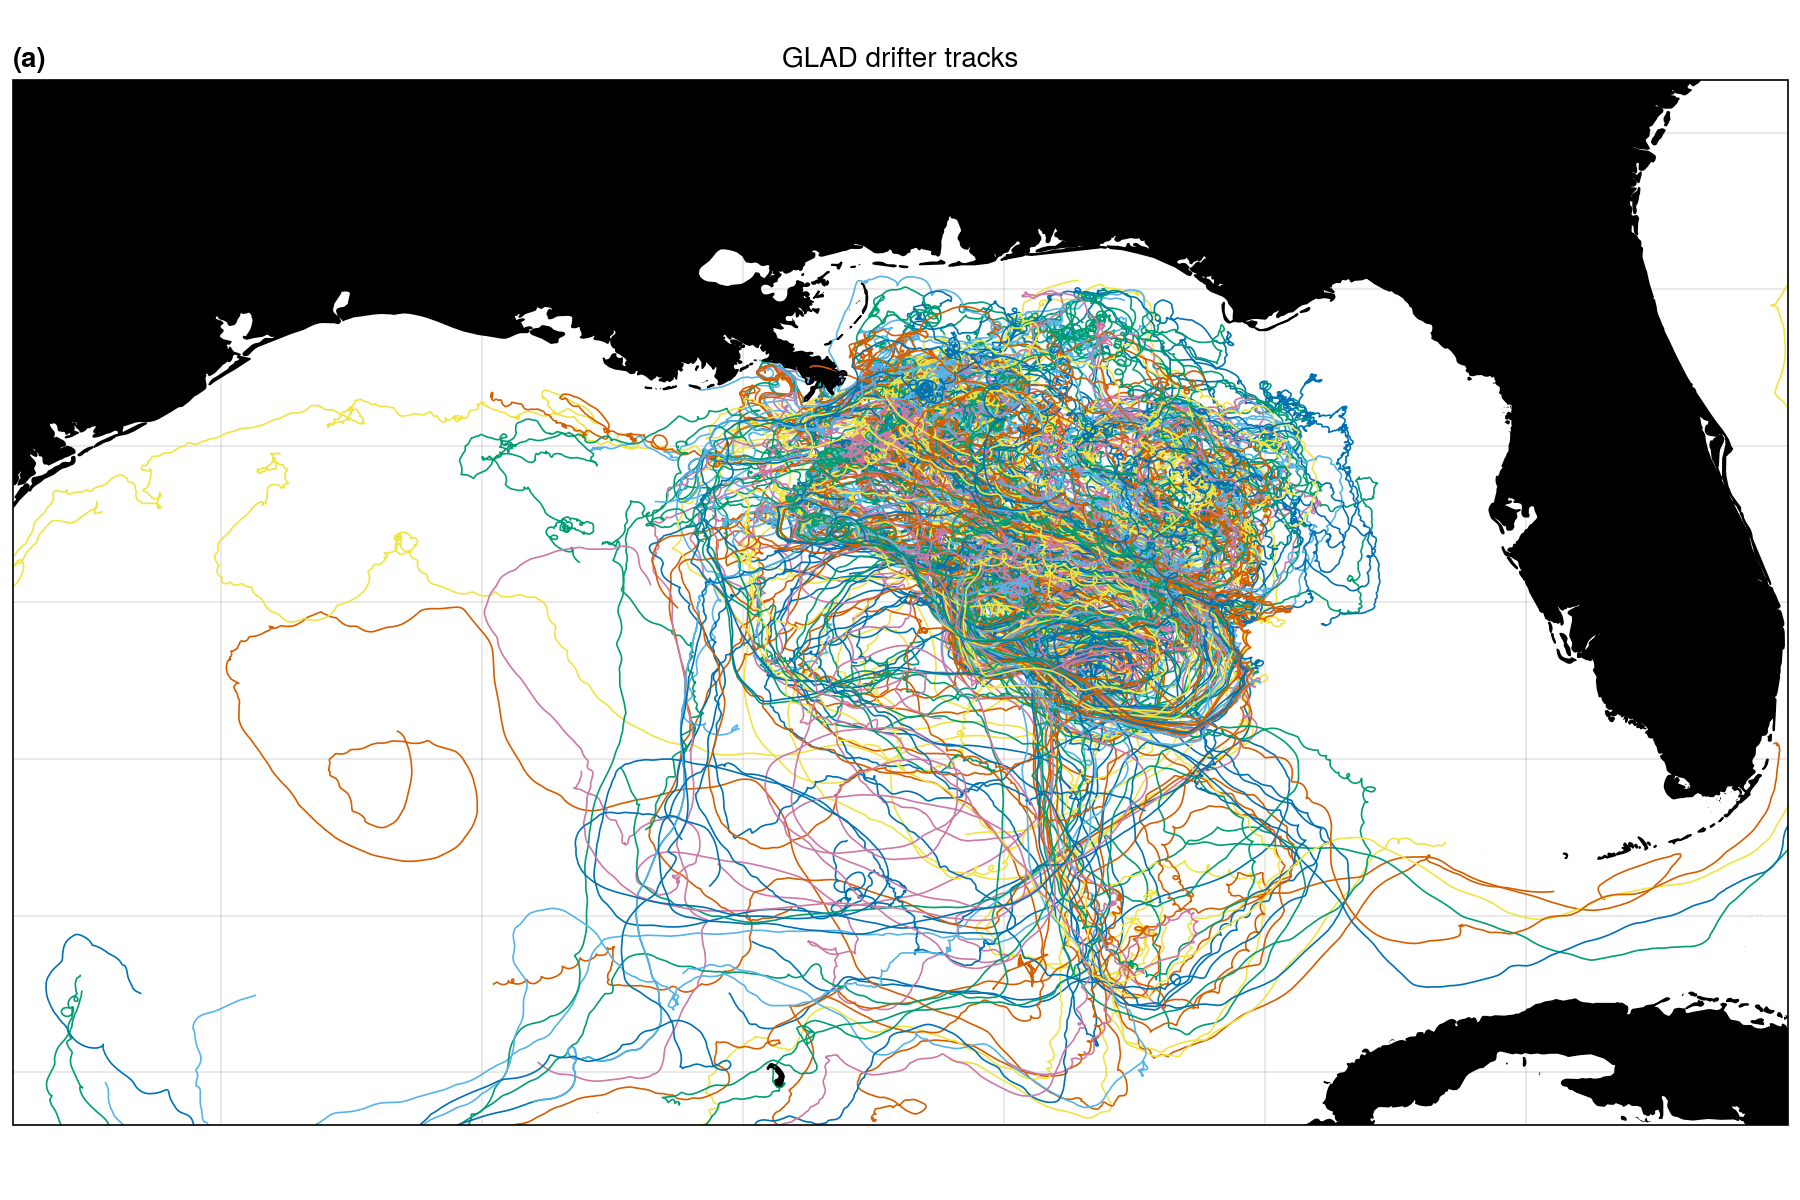

In [9]:
import proplot as pplt

fig, axes = pplt.subplots(nrows=1, ncols=1, figsize=(9, 6), facecolor='w', proj='cyl')

ax = axes[0]
ax.plot(dsFull.lon.values[:, :].T, dsFull.lat.values[:, :].T, lw=0.6)
ax.set_title('GLAD drifter tracks', fontsize=10)

axes.format(abc='(a)', land=True, coast=True, reso='hi', lonlim=[-97, -80], latlim=[22, 32])

/home/qianyk/miniconda3/envs/py310/lib/python3.10/site-packages/proplot/axes/plot.py:1275: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  obj = getattr(super(), name)(*args, **kwargs)
/home/qianyk/miniconda3/envs/py310/lib/python3.10/site-packages/proplot/axes/plot.py:1275: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  obj = getattr(super(), name)(*args, **kwargs)
/home/qianyk/miniconda3/envs/py310/lib/python3.10/site-packages/proplot/axes/plot.py:1275: Matpl

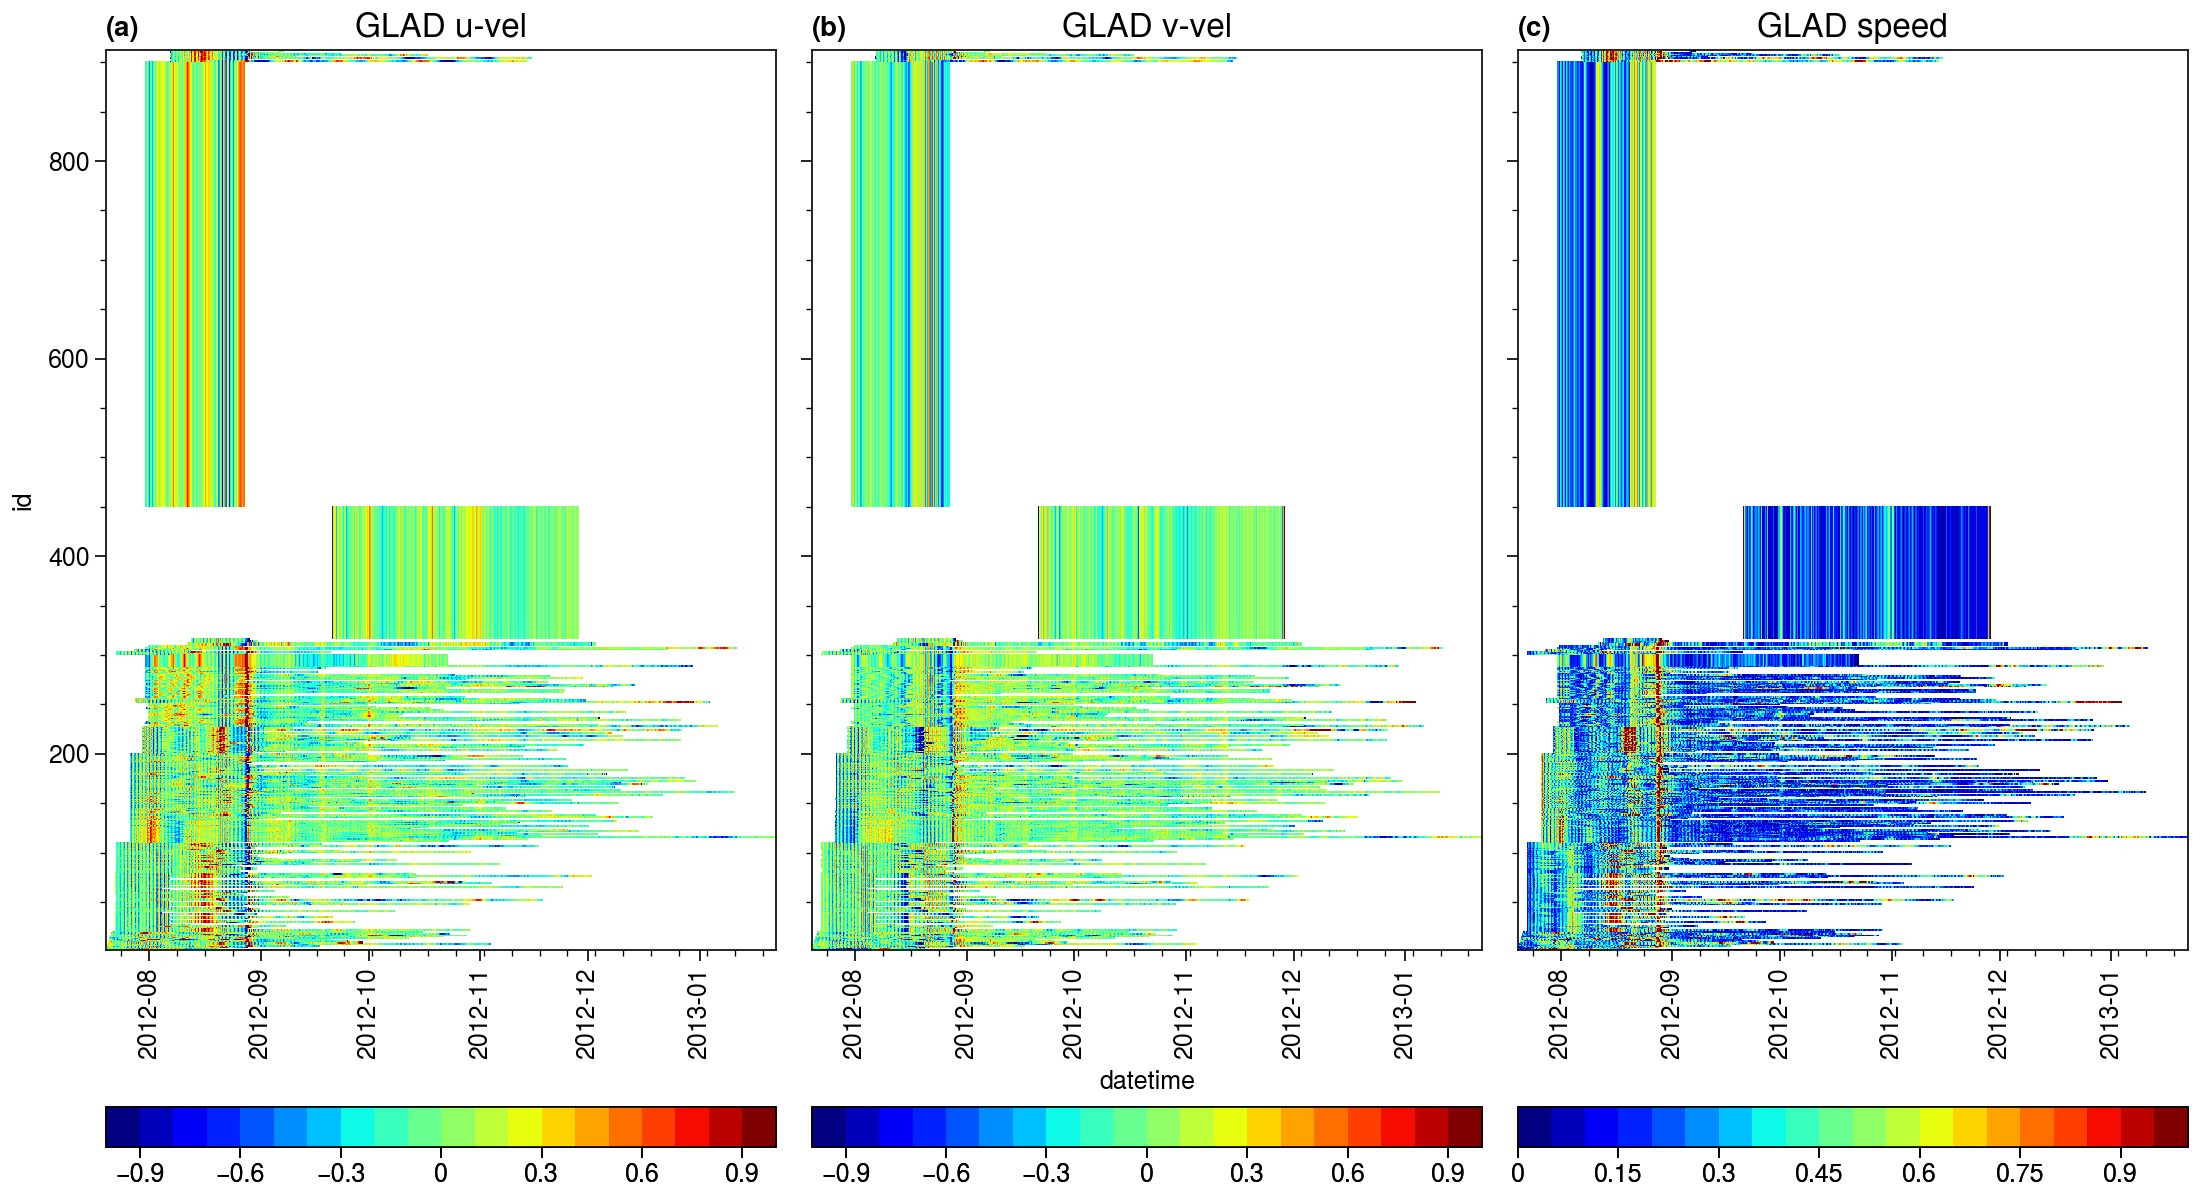

In [10]:
import proplot as pplt

fig, axes = pplt.subplots(ncols=3, nrows=1, figsize=(11, 6), facecolor='w')

ax = axes[0]
m = ax.pcolormesh(dsFull.ve, cmap='jet', levels=np.linspace(-1, 1, 21))
ax.set_title('GLAD u-vel', fontsize=12)
ax.colorbar(m, loc='b', label='')

ax = axes[1]
m = ax.pcolormesh(dsFull.vn, cmap='jet', levels=np.linspace(-1, 1, 21))
ax.set_title('GLAD v-vel', fontsize=12)
ax.colorbar(m, loc='b', label='')

ax = axes[2]
m = ax.pcolormesh(np.hypot(dsFull.vn, dsFull.ve), cmap='jet', levels=np.linspace(0, 1, 21))
ax.set_title('GLAD speed', fontsize=12)
ax.colorbar(m, loc='b', label='')

axes.format(abc='(a)')

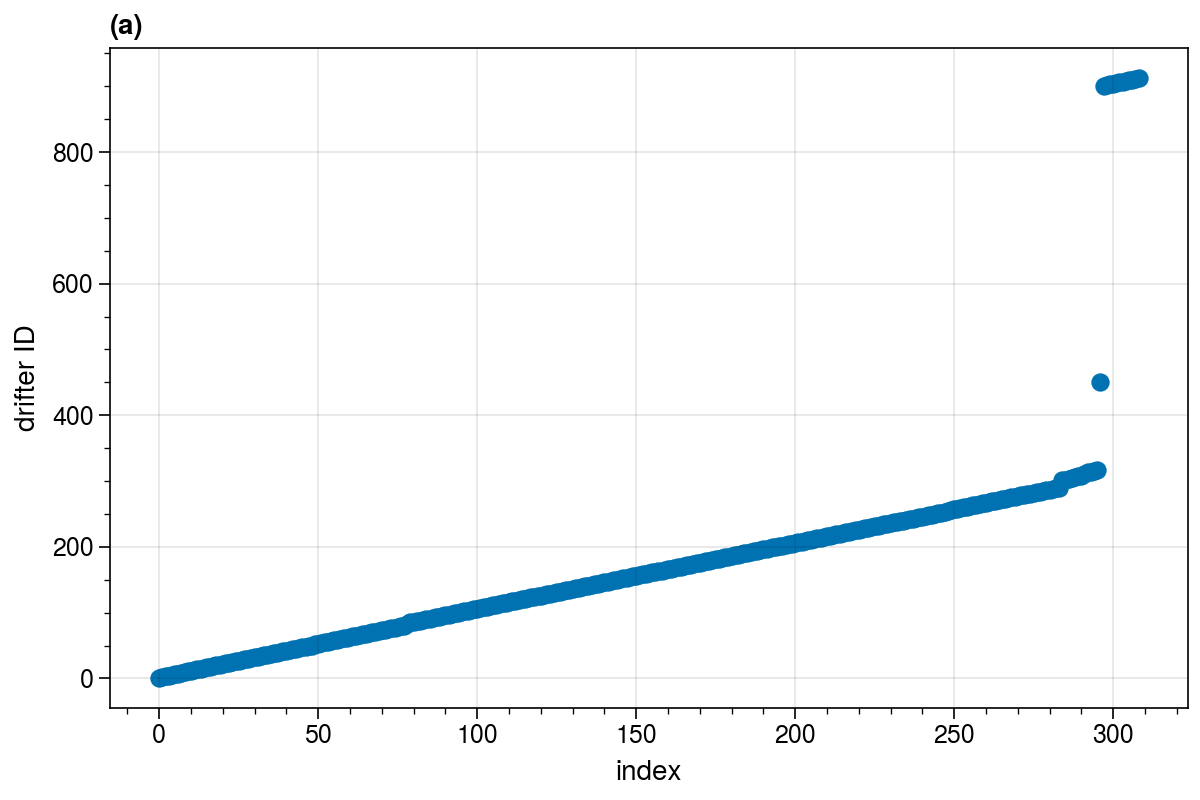

In [11]:
import proplot as pplt

fontsize = 12
fig, axes = pplt.subplots(figsize=(6, 4), facecolor='w')

ax = axes[0]
ax.scatter(np.arange(len(dsFull.id)), dsFull.id)
ax.set_xlabel('index', fontsize=fontsize-2)
ax.set_ylabel('drifter ID', fontsize=fontsize-2)

axes.format(abc='(a)')

In [5]:
dsFull.to_netcdf('/Data/GLAD/ds5minFillna.nc')